In [1]:
import sys 
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal

In [2]:
class Particle: ###Particle5
    def __init__(self, init_pose):
        self.pose = init_pose
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): #追加
        ns = noise_rate_pdf.rvs() #順にnn, no, on, oo
        pnu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        pomega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(pnu, pomega, time, self.pose)

In [3]:
class Mcl: 
    def __init__(self, init_pose, num, motion_noise_stds): 
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
    def motion_update(self, nu, omega, time): ###Mcl5###
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
        
    def draw(self, ax, elems): 
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles] 
        vys = [math.sin(p.pose[2]) for p in self.particles] 
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [4]:
class MclAgent(Agent):        ###MclAgent5
    def __init__(self, time_interval, nu, omega, pf):
        super().__init__(nu, omega)
        self.pf = pf
        self.time_interval = time_interval
        
        self.prev_nu = 0.0       #追加
        self.prev_omega = 0.0 #追加
        
    def decision(self, observation=None): #追加
        self.pf.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.pf.draw(ax, elems)

In [5]:
initial_pose = np.array([0, 0, 0]).T   ###mcl5_test（下の出力の先頭数行を記載）
pf = Mcl(initial_pose, 100, motion_noise_stds={"nn":0.01, "no":0.02, "on":0.03, "oo":0.04})
a = MclAgent(0.1, 0.2, 10.0/180*math.pi, pf)
pf.motion_update(0.2, 10.0/180*math.pi, 0.1)
for p in pf.particles:
    print(p.pose)

[0.02268029 0.00022462 0.01980662]
[0.01907653 0.00038741 0.04061093]
[0.01690593 0.00017824 0.02108551]
[0.01829335 0.000149   0.01628952]
[0.01933298 0.00019815 0.02049801]
[1.42870536e-02 3.48064006e-05 4.87242966e-03]
[0.02451881 0.00017033 0.0138934 ]
[0.02485087 0.00010126 0.00814919]
[0.02006185 0.00018976 0.01891646]
[0.01969454 0.00016429 0.01668359]
[0.02030893 0.00012517 0.01232667]
[0.01600698 0.00010406 0.01300168]
[0.02000662 0.00015679 0.01567352]
[0.01999049 0.00025334 0.02534499]
[0.01852477 0.00022193 0.02395971]
[1.94408386e-02 9.06440500e-05 9.32504972e-03]
[0.01657874 0.0001478  0.01782911]
[0.02079299 0.00027205 0.02616595]
[0.01732263 0.00020951 0.02418793]
[0.02097382 0.0002214  0.02111146]
[2.43741259e-02 6.42298595e-05 5.27031911e-03]
[0.01936169 0.00020599 0.02127768]
[0.0188608  0.00011862 0.012578  ]
[0.01895768 0.00010496 0.01107342]
[0.02024094 0.0001787  0.01765681]
[0.02033454 0.00027296 0.02684573]
[0.01759845 0.00014287 0.01623601]
[0.02074535 0.00013

<IPython.core.display.Javascript object>


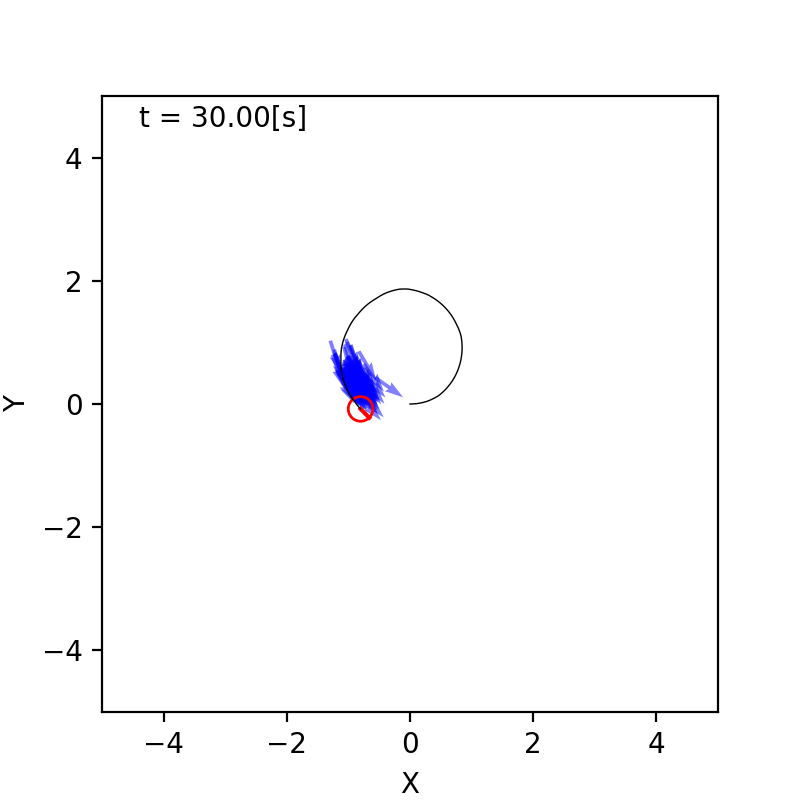

In [6]:
time_interval = 0.1  ###draw_mcl5###
world = World(30, time_interval) 

initial_pose = np.array([0, 0, 0]).T
pf = Mcl(initial_pose, 100, motion_noise_stds={"nn":0.01, "no":0.02, "on":0.03, "oo":0.04})
circling = MclAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
r = Robot(initial_pose, sensor=None, agent=circling, color="red" )
world.append(r)

world.draw()

In [ ]:
time_interval = 0.1  ###mcl5small###
world = World(30, time_interval) 

circling = MclAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T, motion_noise_stds={"nn":0.1, "no":0.2, "on":0.3, "oo":0.1})
r = Robot( np.array([0, 0, 0]).T, sensor=None, agent=circling, color="red" )
world.append(r)

world.draw()

In [ ]:
time_interval = 0.1  ###mcl5small###
world = World(40, time_interval) 

circling = MclAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T, motion_noise_stds={"nn":0.19, "no":0.00001, "on":0.13, "oo":0.2})
r = Robot( np.array([0, 0, 0]).T, sensor=None, agent=circling, color="red")
world.append(r)

world.draw()